In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from iactrace import (
    Telescope, Cylinder, MCIntegrator, HexagonalSensor, SquareSensor, 
    hexshow, plot_telescope_geometry
)

# Import HESS I telescope configuration:

In [4]:
integrator = MCIntegrator(256, 20.0) # This defines the sampler to sample 32 points per mirror facet, also defining microfacet roughness
telescope = Telescope.from_yaml('../configs/HESS/CT1.yaml', integrator, sampling_key = jax.random.key(42))

# Simulating Star field:

In [5]:
# Generate star field
n_stars = 1000
key = jax.random.key(143)
key1, key2 = jax.random.split(key)

# Small angular region (5 degrees field of view)
fov_deg = 5
fov_rad = fov_deg * jnp.pi / 180

x = jax.random.uniform(key1, (n_stars,), minval=-fov_rad/2, maxval=fov_rad/2)
y = jax.random.uniform(key2, (n_stars,), minval=-fov_rad/2, maxval=fov_rad/2)
z = -jnp.ones(n_stars)

stars = jnp.stack([x, y, z], axis=1)
stars = stars / jnp.linalg.norm(stars, axis=1, keepdims=True)

In [6]:
%%time
image_science = telescope(stars, source_type='infinity', sensor_idx=0).block_until_ready()
image_lid = telescope(stars, source_type='infinity', sensor_idx=1).block_until_ready()

CPU times: user 1.99 s, sys: 128 ms, total: 2.12 s
Wall time: 2.52 s


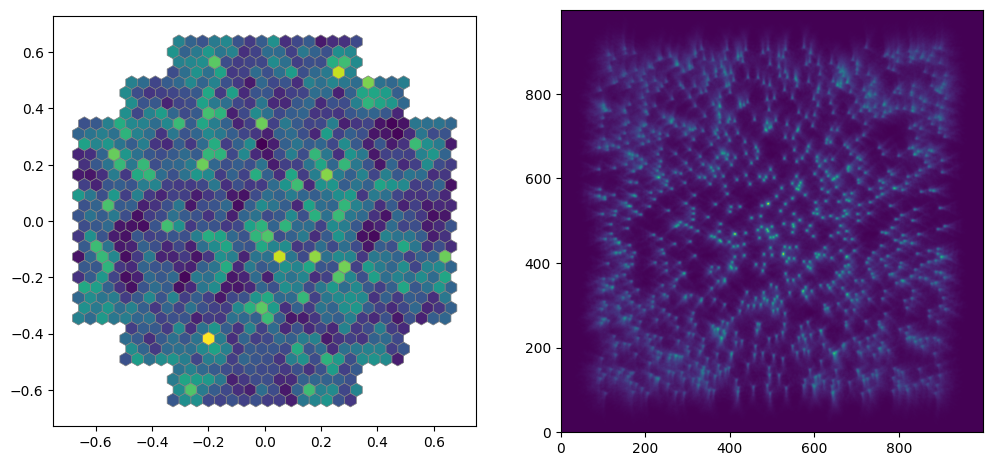

In [7]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
hexshow(image_science, telescope.sensors[0].hex_centers, ax=ax[0])
ax[1].imshow(image_lid, origin='lower')

# Simulating Point Source:

In [29]:
N_points = 1

key = jax.random.key(12)
key1, key2 = jax.random.split(key)

x = jax.random.uniform(key1, N_points, minval=-0.01, maxval=0.01)
y = jax.random.uniform(key2, N_points, minval=-0.01, maxval=0.01)
z = jnp.ones(N_points) * 240

points = jnp.array([x,y,z]).T

In [30]:
%%time
image_science = telescope(points, source_type='point', sensor_idx=0).block_until_ready()
image_lid = telescope(points, source_type='point', sensor_idx=1).block_until_ready()

CPU times: user 9.97 ms, sys: 1.21 ms, total: 11.2 ms
Wall time: 30.8 ms


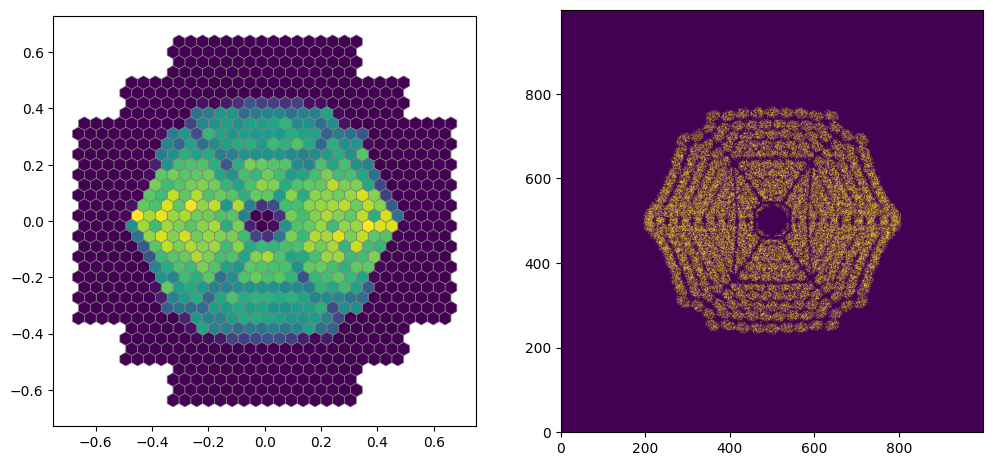

In [31]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
hexshow(image_science, telescope.sensors[0].hex_centers, ax=ax[0])
ax[1].imshow(image_lid, origin='lower', vmax=1)